### IMPORTACIÓN DE LIBRERIAS NECESARIAS

In [1]:
import tensorflow as tf
import keras
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
from random import sample
import shutil
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import model_from_json

# MEJORA DEL MODELO

Realizar una red neuronal desde cero con un conjunto de datos de más de 20000 imágenes es muy costoso computacionalmente en un ordenador personal.

Sin embargo, para que el modelo sea potente y que los resultados se puedan generalizar es necesario que tenga muchas imágenes.
Una manera de tener imágenes suficientes y poder utilizar un ordenador personal es la utilización del método **Data Augmentation**.

Dicho método consiste en generar más datos, en nuestro caso más imágenes, a partir de nuestros datos de entrenamiento, introduciendo transformaciones aleatorias en las imágenes, de manera que estas tengan un aspecto creible.

#### 1º IMPORTAR LOS DATOS

Nuestro conjunto de datos está formado por más de 21000 imágenes pertenecientes a cuatro clases. Para realizar **data augmentation** cogeremos 1000 imágenes de cada clase para el train y 300 imágenes de cada clase para el valid.

Creamos un directorio llamado _Data_ y los subdirectorios _Train_ y _Valid_ 

In [3]:
os.makedirs('/Data', exist_ok = True)
os.makedirs('/Data/Train', exist_ok=True)
os.makedirs('/Data/Valid', exist_ok=True)

Establecemos el directorio de nuestro ordenador donde se encuentra nuestro data set completo.

In [4]:
directorio = 'C:/Users/blanca/Desktop/UOC/3º SEMESTRE/TFM/COVID-19_Radiography_Dataset'

Ahora vamos a ir "rellenando" ambos subdirectorios con las imágenes ordenadas en carpetas según su clase. La elección de las imágenes se hará de forma aleatoria. 

In [5]:
# Establecemos la semilla de pseudoaleatorización
random.seed('123456')

# Creamos las listas 
carpetas = []
clases = []

# Leemos las carpetas de nuestro directorio, hay 4, una por cada clase
for carpeta in os.listdir(directorio):
    # Establecemos la ruta de cada carpeta
    carpeta_path = os.path.join(directorio,carpeta)
    # Juntamos las rutas de las carpetas en la lista *carpetas*
    carpetas.append(carpeta_path)
    
# Leemos cada una de las carpetas que corresponde con cada una de las clases
for carpeta in carpetas:
    # Establecemos el nombre de la carpeta que será el nombre de la clase
    nombre = carpeta.split(sep ='\\')[-1]
    clases.append(nombre)
    
    # Creamos dentro de los directorios Train y Valid las carpetas para cada clase
    os.makedirs('/Data/Train/' + nombre, exist_ok = True)
    os.makedirs('/Data/Valid/' + nombre, exist_ok = True)
    
    
    archivos = []
    train_clase = []
    valid_clase = []
    # Leemos los archivos (imágenes) de cada carpeta 
    for archivo in os.listdir(carpeta):
        archivos.append(archivo)
    # Seleccionamos 1000 + 300 imágenes de cada carpeta
    seleccion = sample(archivos, 1300)
    
    # Dividimos las imágenes seleccionadas en train y valid
    train_clase = seleccion[:1000]
    valid_clase = seleccion[1000:]
    
    # Copiamos las imágenes de train y valid en sus respectivas carpetas
    for imagen in train_clase:
        img_path = os.path.join(carpeta, imagen)
        shutil.copy(img_path, os.path.join('/Data/Train',nombre, imagen))
    for imagen in valid_clase:
        img_path = os.path.join(carpeta, imagen)
        shutil.copy(img_path, os.path.join('/Data/Valid',nombre, imagen))

#### DATA AUGMENTATION

Comprobamos como funciona **data augmentation** con nuestros datos. Utilzamos la función ImageDataGenerator de keras.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.05,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = False,
        fill_mode='nearest')

In [36]:
# Elegimos de forma aleatoria la imagen que va a ser "aumentada"

from random import randrange

# Elegimos de forma aleatoria la clase
clase_elegida = random.choice(clases)
x = clases.index(clase_elegida)
rango = list(os.listdir(carpetas[x]))
num = random.choice(rango)


# Cargamos la imagen elegida de forma aleatoria
img_prueba = load_img(os.path.join(carpetas[x],num))

# Transformamos la imagen PIL en un numpy array
img_prueba_array = img_to_array(img_prueba)

# Redimensionamos la imagen
img_shape = img_prueba_array.reshape((1,) + img_prueba_array.shape)

os.makedirs('/Data/Ejemplo', exist_ok=True)
i = 0
for batch in data_gen.flow(img_shape, 
                           batch_size=1,
                           save_to_dir='/Data/Ejemplo'):
    i += 1
    if i > 20:
        break

Mostramos la imagen original:

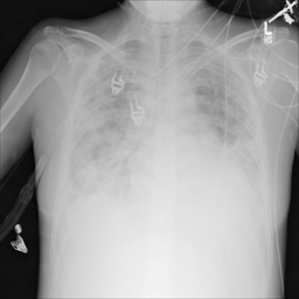

In [37]:
img_prueba

Mostramos una imagen aumentada:

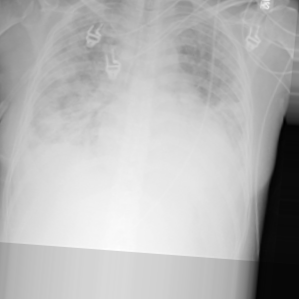

In [71]:
img_aum = []
for imagen in os.listdir('/Data/Ejemplo'):  
    imagen_path = os.path.join("C:\Data\Ejemplo",imagen)
    img_aum.append(imagen_path)
load_img(img_aum[1])

Ahora vamos a realizar el data augmentation con todos los datos. 

Primero establacemos la configuración del aumento de datos para el train, el test y el valid data. Para el test y el valid data solo se normalizarán los datos.

Después creamos el generador de datos para cada conjunto. 

In [9]:
batch_size = 20

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(
        '/Data/Train',
        target_size=(299, 299),  
        batch_size=batch_size,
        class_mode='binary')  

test_generator = test_datagen.flow_from_directory(
        '/Data/Valid',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        '/Data/Valid',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')



Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


A continuación creamos el modelo de red neuronal convolucional.

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(299, 299, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(4))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 297, 297, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        1

Ahora entrenamos nuestro modelo con los generadores de imágenes creados.

In [296]:
batch_size = 50
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 4000 // batch_size,
    epochs = 50,
    validation_data=validation_generator,
    validation_steps= 1200 // batch_size)
model.save_weights('first_try.h5')

Epoch 1/50
80/80 [==============================] - 247s 3s/step - loss: 0.6898 - accuracy: 0.7375 - val_loss: 0.6468 - val_accuracy: 0.7604
Epoch 2/50
80/80 [==============================] - 242s 3s/step - loss: 0.6879 - accuracy: 0.7275 - val_loss: 0.5911 - val_accuracy: 0.7917
Epoch 3/50
80/80 [==============================] - 241s 3s/step - loss: 0.6992 - accuracy: 0.7250 - val_loss: 0.6068 - val_accuracy: 0.7708
Epoch 4/50
80/80 [==============================] - 241s 3s/step - loss: 0.6741 - accuracy: 0.7406 - val_loss: 0.5696 - val_accuracy: 0.8021
Epoch 5/50
80/80 [==============================] - 241s 3s/step - loss: 0.6696 - accuracy: 0.7356 - val_loss: 0.5587 - val_accuracy: 0.7521
Epoch 6/50
80/80 [==============================] - 245s 3s/step - loss: 0.6500 - accuracy: 0.7619 - val_loss: 0.6174 - val_accuracy: 0.7500
Epoch 7/50
80/80 [==============================] - 242s 3s/step - loss: 0.6875 - accuracy: 0.7319 - val_loss: 0.6046 - val_accuracy: 0.7729
Epoch 8/50
80

Evaluamos el modelo:

In [25]:
model.evaluate(test_generator)

60/60 [==============================] - 51s 852ms/step - loss: 0.4289 - accuracy: 0.8592


[0.428889662027359, 0.85916668176651]

Guardamos el modelo:

In [26]:
model_json = model.to_json()
model.save_weights("model.h5py")

Observamos los resultados

In [ ]:
history_dict = history.history
print(history_dict.keys())

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

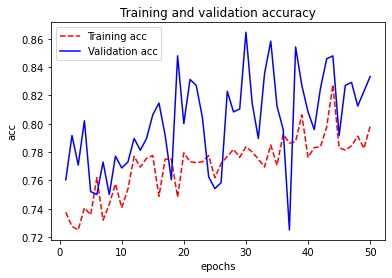

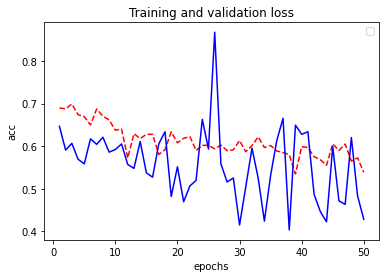

<Figure size 432x288 with 0 Axes>

In [299]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

## TRANSFER LEARNING

Otra forma de mejorar nuestro modelo es untilizar un modelo preentrenado. Utilizaremos la covnet **VGG16**.

Cargamos el modelo VGG16. Damos la *instrucción include_top = False* para poder utilizar nuestro propio clasificador densamente conectado con cuatro clases.

In [12]:
from tensorflow.keras.applications import VGG16

VGG16_model = VGG16(input_shape = (299,299,3),
                        include_top = False,
                        weights = 'imagenet')

VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

### Extracción de características sin aumento de datos

Primero probaremos el modelo VGG16 sin aumento de datos. 
Crearemos las listas de imagenes de train y valid y sus correspondientes etiquetas.

In [13]:
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Leemos los archivos de Train
for root, dirs, files in os.walk('/Data/Train'):
    # Leemos cada imagen
    for filename in files:
        # Obtenemos su ruta
        img_path = os.path.join(root, filename)
        # Cargamos la imagen
        img = load_img(img_path)
        # Convertimos la imagen en array
        img = img_to_array(img)
        # Redimentsionamos la imagen
        img = np.expand_dims(img, axis = 0)
        # Incluimos la imagen en su lista 
        train_images.append(img)
        # Obtenemos la clase de cada imagen según su nombre
        x = filename.split(sep ='-')
        x = x[0]
        # Añadimos la clase a la lista de labels
        train_labels.append(x)
    
    
# Realizamos el mismo procedimiento con las imagenes de Valid
for root, dirs, files in os.walk('/Data/Valid'):
    for filename in files:
        img_path = os.path.join(root, filename)
        img = load_img(img_path)
        img = img_to_array(img)
        img = np.expand_dims(img, axis = 0)
        valid_images.append(img)
        x = filename.split(sep ='-')
        x = x[0]
        valid_labels.append(x)

Codificamos las etiquetas:

In [14]:
dic = {'COVID':0, 'Lung_Opacity':1, 'Normal':2, 'Viral Pneumonia': 3}
train_labels = [dic.get(n, n) for n in train_labels]
valid_labels = [dic.get(n, n) for n in valid_labels]


Extraemos características:

In [15]:
train_features = []

for img in train_images:
    img_preprocessed = keras.applications.vgg16.preprocess_input(img)
    feature = VGG16_model.predict(img_preprocessed)
    train_features.append(feature)
train_features = np.concatenate(train_features)

In [16]:
valid_features = []

for img in valid_images:
    img_preprocessed = keras.applications.vgg16.preprocess_input(img)
    feature = VGG16_model.predict(img_preprocessed)
    valid_features.append(feature)
valid_features = np.concatenate(valid_features)

In [19]:
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

Establecemos el modelo densamente conectado:

In [20]:
inputs = keras.Input(shape=(9, 9, 512))

x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(4, activation='softmax')(x)

model1 = keras.Model(inputs, outputs)
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='feature_extraction.keras',
    save_best_only=True,
    monitor='val_loss')]

history1 = model1.fit(
  train_features, train_labels,
  epochs=50,
  validation_data=(valid_features, valid_labels),
  callbacks=callbacks)

Epoch 1/50
125/125 [==============================] - 32s 259ms/step - loss: 64.0170 - accuracy: 0.7665 - val_loss: 15.8945 - val_accuracy: 0.9092
Epoch 2/50
125/125 [==============================] - 29s 236ms/step - loss: 21.2788 - accuracy: 0.8845 - val_loss: 28.4804 - val_accuracy: 0.8758
Epoch 3/50
125/125 [==============================] - 30s 237ms/step - loss: 12.6797 - accuracy: 0.9202 - val_loss: 24.1286 - val_accuracy: 0.8867
Epoch 4/50
125/125 [==============================] - 29s 232ms/step - loss: 10.9765 - accuracy: 0.9350 - val_loss: 24.3133 - val_accuracy: 0.8992
Epoch 5/50
125/125 [==============================] - 29s 231ms/step - loss: 6.5536 - accuracy: 0.9555 - val_loss: 18.2486 - val_accuracy: 0.9067
Epoch 6/50
125/125 [==============================] - 29s 230ms/step - loss: 6.6166 - accuracy: 0.9560 - val_loss: 20.6486 - val_accuracy: 0.9108
Epoch 7/50
125/125 [==============================] - 29s 232ms/step - loss: 4.1157 - accuracy: 0.9680 - val_loss: 23.95

Guardamos el modelo:

In [21]:
model1_json = model1.to_json()
model1.save_weights("model1.h5py")

Evaluamos el modelo:

In [428]:
test_lost, test_acc= model1.evaluate(valid_features, valid_labels)
print ("Test Accuracy:", test_acc)

38/38 [==============================] - 2s 58ms/step - loss: 99.2840 - accuracy: 0.8258
Test Accuracy: 0.8258333206176758


Mostramos los resultados:

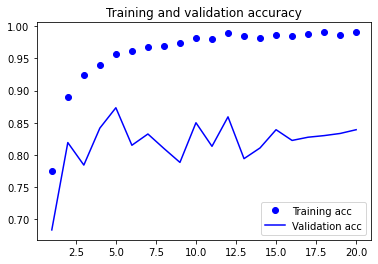

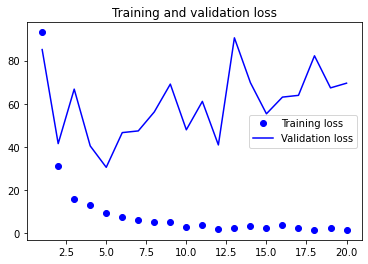

In [423]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Extracción de características junto con aumento de datos

Congelamos la base convolucional del modelo:

In [22]:
print('This is the number of trainable weights before freezing the conv base:', len(VGG16_model.trainable_weights))

VGG16_model.trainable = False

print('This is the number of trainable weights after freezing the conv base:', len(VGG16_model.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


Contruimos el modelo

In [23]:
x = keras.layers.Flatten()(VGG16_model.output)

x = keras.layers.Dense(512, activation='relu')(x)

x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Dense(4, activation='softmax')(x)

model2 = tf.keras.models.Model(VGG16_model.input, x)

model2.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])


Entrenamos el modelo con el aumento de datos.

In [24]:
vgghist = model2.fit(train_generator, 
                     validation_data = validation_generator, 
                     steps_per_epoch = 100, 
                     epochs = 10)


Epoch 1/10
100/100 [==============================] - 2774s 28s/step - loss: 1.1917 - accuracy: 0.5505 - val_loss: 0.6425 - val_accuracy: 0.7325
Epoch 2/10
100/100 [==============================] - 2680s 27s/step - loss: 0.7645 - accuracy: 0.6870 - val_loss: 0.5722 - val_accuracy: 0.7775
Epoch 3/10
100/100 [==============================] - 2671s 27s/step - loss: 0.6660 - accuracy: 0.7370 - val_loss: 0.5663 - val_accuracy: 0.7825
Epoch 4/10
100/100 [==============================] - 2803s 28s/step - loss: 0.5850 - accuracy: 0.7625 - val_loss: 0.4752 - val_accuracy: 0.8200
Epoch 5/10
100/100 [==============================] - 2805s 28s/step - loss: 0.5661 - accuracy: 0.7805 - val_loss: 0.5552 - val_accuracy: 0.7567
Epoch 6/10
100/100 [==============================] - 2799s 28s/step - loss: 0.5812 - accuracy: 0.7680 - val_loss: 0.3944 - val_accuracy: 0.8508
Epoch 7/10
100/100 [==============================] - 2807s 28s/step - loss: 0.5055 - accuracy: 0.8025 - val_loss: 0.3974 - val_ac

In [78]:
model2.evaluate(test_generator)

60/60 [==============================] - 1440s 24s/step - loss: 0.3460 - accuracy: 0.8750


[0.34598997235298157, 0.875]

Guardamos el modelo:

In [25]:
model2_json = model2.to_json()
model2.save_weights("model2.h5py")

Mostramos los resultados:

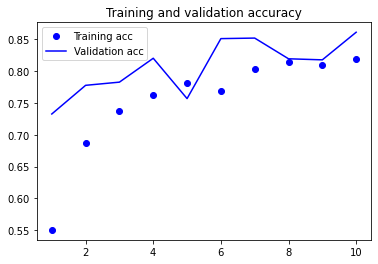

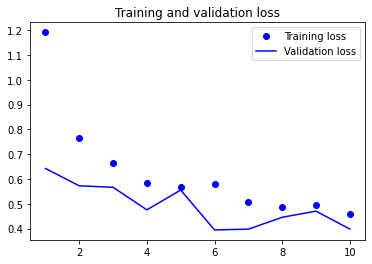

In [80]:
import matplotlib.pyplot as plt
acc = vgghist.history['accuracy']
val_acc = vgghist.history['val_accuracy']
loss = vgghist.history['loss']
val_loss = vgghist.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## FINE TUNING

Por último vamos a utilizar la técnica **fine tuning** para mejorar el rendimiento del modelo. Este método consiste en descongelar algunas de las capas superiores de un modelo previamente entrenado que hemos congelado, en nuestro caso VGG16, y entrenar conjuntamente tanto la parte que hemos agregado en el apartado anterior, el clasificador completamente conectado, como estas capas superiores.

Importamos de nuevo el modelo VGG16:

In [26]:
VGG16_model = VGG16(input_shape = (299,299,3),
                   include_top = False,
                   weights = 'imagenet')

VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

Congelamos todas lascapas hasta la cuarta desde la última:

In [27]:
VGG16_model.trainable = True

In [28]:
for layer in VGG16_model.layers[:-4]:
    layer.trainable = False

Compilamos y entrenamos de nuevo el modelo:

In [29]:
model2.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='fine_tuning.keras',
    save_best_only=True,
    monitor='val_loss')]

history3 = model2.fit(
    train_generator,
    epochs = 10,
    steps_per_epoch = 100,
    validation_data = validation_generator,
    callbacks = callbacks)

Epoch 1/10
100/100 [==============================] - 2880s 29s/step - loss: 0.3579 - accuracy: 0.8675 - val_loss: 0.3663 - val_accuracy: 0.8625
Epoch 2/10
100/100 [==============================] - 2752s 28s/step - loss: 0.3439 - accuracy: 0.8645 - val_loss: 0.3505 - val_accuracy: 0.8742
Epoch 3/10
100/100 [==============================] - 2655s 27s/step - loss: 0.3622 - accuracy: 0.8685 - val_loss: 0.3498 - val_accuracy: 0.8775
Epoch 4/10
100/100 [==============================] - 2692s 27s/step - loss: 0.3363 - accuracy: 0.8815 - val_loss: 0.3487 - val_accuracy: 0.8667
Epoch 5/10
100/100 [==============================] - 2771s 28s/step - loss: 0.3465 - accuracy: 0.8760 - val_loss: 0.3617 - val_accuracy: 0.8608
Epoch 6/10
100/100 [==============================] - 2781s 28s/step - loss: 0.3290 - accuracy: 0.8800 - val_loss: 0.3718 - val_accuracy: 0.8550
Epoch 7/10
100/100 [==============================] - 2772s 28s/step - loss: 0.3445 - accuracy: 0.8730 - val_loss: 0.3816 - val_ac

Guardamos el modelo:

In [30]:
model3_json = model2.to_json()
model2.save_weights("model3.h5py")

Evaluamos el modelo:

In [460]:
test_loss, test_acc = model2.evaluate(test_generator)
print('Test accuracy: %.3f' % (test_acc,))

60/60 [==============================] - 890s 15s/step - loss: 0.3664 - accuracy: 0.8642
Test accuracy: 0.864


Mostramos los resultados:

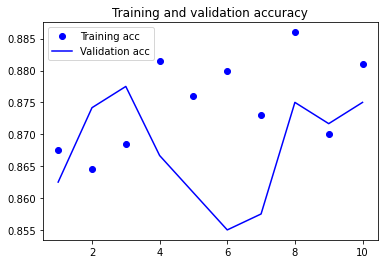

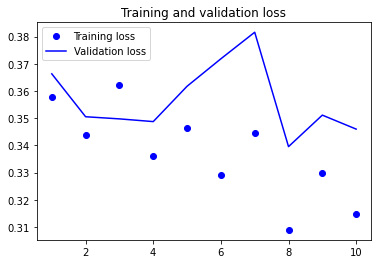

In [81]:
import matplotlib.pyplot as plt
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()